In [ ]:
# Author    :   Danish Ansari
# Date      :   28.12.2021
# Version   :   1.4
# Description:  Build an agent that learns to pick the best request using DQN

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys
my_dir = '/content/drive/MyDrive/CabDriver/'
sys.path.insert(0,my_dir)

pathToSave = '/content/drive/MyDrive/SavedModels/'

### Cab-Driver Agent

In [3]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from tensorflow.keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

In [4]:
env = CabDriver()
actionSpace, stateSpace, state = env.reset()

#### Defining Time Matrix

In [5]:
# Loading the time matrix provided
Time_matrix = np.load(my_dir + '/' + 'TM.npy')

In [6]:
# Time_matrix
print(Time_matrix.max())
print(Time_matrix.min())

11.0
0.0


In [7]:
Time_matrix.shape

(5, 5, 24, 7)

#### Tracking the state-action pairs for checking convergence


In [8]:
Time_matrix[1][3][12][2]

1.0

In [9]:
Time_matrix[1][4][13]#[2]

array([0., 0., 0., 0., 2., 0., 2.])

In [10]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [11]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.9
        self.learning_rate =  0.01
        self.epsilon_max = 1.0
        self.epsilon_decay = 0.001 #0.0008 #0.00002
        self.epsilon_min = 0.00001
        
        self.batch_size = 32
        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        #States to track
        self.stateToTrack_1 = env.state_encod_arch2((2,3,5)).reshape(1, 36)
        self.stateToTrack_2 = env.state_encod_arch2((1,3,4)).reshape(1, 36)
        self.trackDataState1 = []
        self.trackDataState2 = []

        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    
    def build_model(self):
        model = Sequential()
        # Write your code here: Add layers to your neural nets
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform', input_dim= self.state_size))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        model.summary()
        return model



    def get_action(self, state, possible_actions_index, epsilon):
        # Write your code here:
        # get action from model using epsilon-greedy policy
        # Decay in ε after we generate each sample from the environment
        random_val = np.random.rand() 
        if random_val > epsilon:
            # model.predict(state)
            # best action - from possible action
            stateVec = np.array(env.state_encod_arch2(state)).reshape(1,36)
            qVals = self.model.predict(stateVec)
            qValsValid = [qVals[0][i] for i in possible_actions_index]
            return possible_actions_index[np.argmax(qValsValid)]
        else:
            #randomly select the actions - from possible action
            return random.choice(possible_actions_index)


    def append_sample(self, state, action, reward, next_state, isTerminal):
        self.memory.append((state, action, reward, next_state, isTerminal))
    # Write your code here:
    # save sample <s,a,r,s'> to the replay memory
    
    
    
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            # [(s,a,r,s'),(s,a,r,s') .... ]

            update_input = np.zeros((self.batch_size,self.state_size))# write here
            update_output = np.zeros((self.batch_size,self.state_size))# write here            
            actions, rewards, terminal_states = [], [], []

            for i in range(self.batch_size):
                state, action, reward, next_state, isTerminal = mini_batch[i]
                
                actions.append(action)
                rewards.append(reward)
                terminal_states.append(isTerminal)
                
                # Write your code from here
                # 1.  Update your 'update_output' and 'update_input' batch
                update_input[i] = env.state_encod_arch2(state)
                update_output[i] = env.state_encod_arch2(next_state)

            target = self.model.predict(update_input)
            target_qval = self.model.predict(update_output) ## (batchsize,len(action_space))

            #print('Shape of target = ', target.shape)
                        
            for i in range(self.batch_size):
                if terminal_states[i]:
                  target[i][actions[i]] = rewards[i]
                else:
                  target[i][actions[i]] = rewards[i]+ self.discount_factor * np.max(target_qval[i])

            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)
                
        # 4. Fit your model and track the loss values

    def save_tracking_states(self):
        qVal1 = self.model.predict(self.stateToTrack_1)
        qVal2 = self.model.predict(self.stateToTrack_2)
        self.trackDataState1.append(qVal1[0][10])           # Action at index 10 => (2,1)
        self.trackDataState2.append(qVal2[0][6])            # Action at index 6 => (1,2)


    def save_model(self, name):
        self.model.save_weights(name + '.h5')
        save_obj(self.model, name)


    def save_tracking_data(self, name):
        save_obj(self.trackDataState1, name + '_trackDataState1')
        save_obj(self.trackDataState2, name + '_trackDataState2')

In [12]:
Episodes = 4000 #200000
state_size = env.state_size
action_size = env.action_size
print('State size = ', state_size)
print('Action size = ', action_size)

State size =  36
Action size =  21


### DQN block

In [13]:
import time
startTime = time.time()
totalRewardEp_track = []
agent = DQNAgent(state_size, action_size)
epsilon = agent.epsilon_max
for episode in range(Episodes):
    # Write code here
    # Call the environment
    # Call all the initialised variables of the environment
    #Call the DQN agent
    count=0
    totalRewardEp = 0
    terminal_state = False
    env = CabDriver()
    actionSpace, stateSpace, state = env.reset()
    initialState = state
    # print('DNA Logs: Episode No. - ' + str(episode))
    while not terminal_state:
        count+=1
        #print('___DNA Logs: Step No. - ' + str(count))
        possible_actions_index,actions = env.requests(state)
        # print('______DNA Logs: Length of possible_actions_index - ' + str(len(possible_actions_index)))
        # print('______DNA Logs: Length of actions - ' + str(len(actions)))
        # print('______DNA Logs: Length of actions - ' ,actions)
        action_index = agent.get_action(state,possible_actions_index,epsilon)
        action = env.action_space[action_index]
        next_state, reward, terminal_state = env.step(state,action,Time_matrix)
        if not terminal_state:
          agent.append_sample(state, action_index, reward, next_state,terminal_state)
          if count%10 ==0:
            agent.train_model()
          totalRewardEp += reward
          state = next_state
        #Append the experience to the memory
        # Write your code here
        # 1. Pick epsilon-greedy action from possible actions for the current state
        # 2. Evaluate your reward and next state
        # 3. Append the experience to the memory
        # if count%10 == 0:
        # 4. Train the model by calling function agent.train_model
        # 5. Keep a track of rewards, Q-values, loss
        # if count%10 ==0:
        #     agent.train_model()
    totalRewardEp_track.append(totalRewardEp)    
    epsilon = agent.epsilon_min + (agent.epsilon_max - agent.epsilon_min) * np.exp(-1 * agent.epsilon_decay * episode)  

    if ((episode+1)%50 == 0):
        print('Episode:' + str(episode+1) +
                ' Reward:' + str(totalRewardEp) +
                ' Total Time:' + str(env.time_elapsed_episode) +
                ' Memory Length:' + str(len(agent.memory)))
        agent.save_tracking_states()

    if((episode+1) % 1000 == 0):
        print('Saving the model, model weights, tracked states, and episode-wise rewards at episode: ', str(episode + 1))
        agent.save_model(name = pathToSave + 'model_' + str(episode + 1))
        agent.save_tracking_data(name = pathToSave + 'ep' + str(episode + 1))
        save_obj(totalRewardEp_track, pathToSave + 'Episode_wise_rewards_till_ep_' + str(episode + 1))

elapsedTime = time.time() - startTime
print('Elapsed Time: ', elapsedTime)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                1184      
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 21)                693       
                                                                 
Total params: 2,933
Trainable params: 2,933
Non-trainable params: 0
_________________________________________________________________
Episode:50 Reward:-218.0 Total Time:722.0 Memory Length:2000
Episode:100 Reward:-331.0 Total Time:722.0 Memory Length:2000
Episode:150 Reward:-83.0 Total Time:725.0 Memory Length:2000
Episode:200 Reward:-223.0 Total Time:721.0 Memory Length:2000
Episode:250 Reward:133.0 Total Time:723.0 Memory Length:2000
Episode:300

In [14]:
#Saving the final model, model weights, and states tracking data
print('Saving the model, model weights, tracked states, and episode-wise rewards at episode: ', str(episode + 1))
agent.save_model(name = pathToSave + 'model_final_' + str(episode + 1))
agent.save_tracking_data(name = pathToSave + 'ep' + str(episode + 1) + '_final_')
save_obj(totalRewardEp_track, pathToSave + 'Episode_wise_rewards_till_ep_' + str(episode + 1) + '_final')

Saving the model, model weights, tracked states, and episode-wise rewards at episode:  4000
INFO:tensorflow:Assets written to: ram://3939db3b-9fa4-4eda-a10f-6e1217a76f23/assets


### Tracking Convergence

In [29]:
def plotQValConvergence(fig_num, state, action, states_tracked):
    plt.figure(fig_num, figsize=(10,4))
    plt.title(f"Convergence of Q_values for state {state} and action {action}", fontsize=14, fontweight='bold')
    xaxis = np.asarray(range(0, len(states_tracked))) * 50
    plt.plot(xaxis,np.asarray(states_tracked))
    plt.ylabel("Q_values", fontsize=13, fontstyle='italic')
    plt.xlabel("No. of Episodes", fontsize=13, fontstyle='italic')
    plt.show()

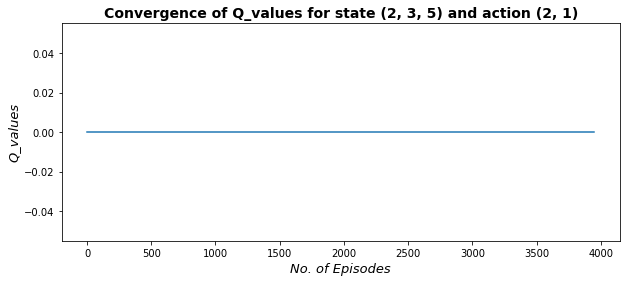

In [30]:
plotQValConvergence(fig_num=1, state=(2,3,5), action=(2,1), states_tracked = agent.trackDataState1)

Starting from state (2,3,5), the predicted Q values for the action (2,1) have always been 0, which means this would be a bad action to take from this state.

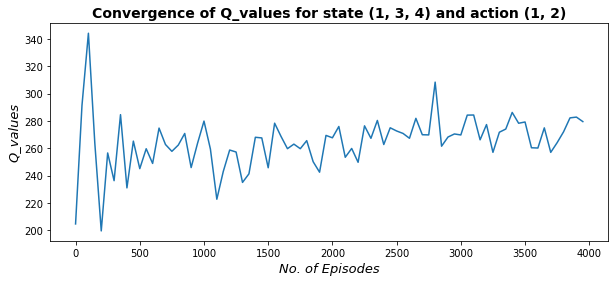

In [31]:
plotQValConvergence(fig_num=2, state=(1,3,4), action=(1,2), states_tracked = agent.trackDataState2)

Here we can see that Q value for taking action (1,2) from state (1,3,4) have somewhat converged at around 3000 episodes

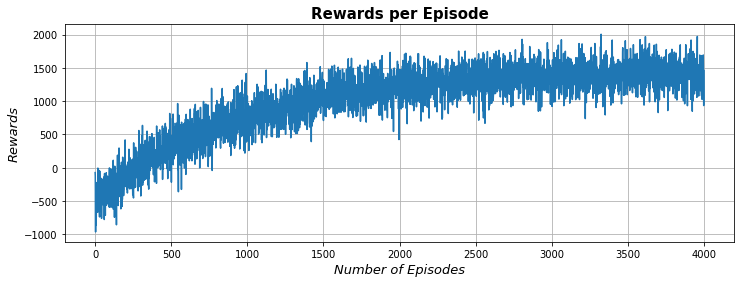

In [32]:
#Checking for convergence of total rewards per episode to a stable figure
plt.figure(1, figsize=(12,4))
plt.title('Rewards per Episode', fontsize=15, fontweight='bold')
xaxis = np.asarray(range(0, len(totalRewardEp_track)))
plt.plot(xaxis,np.asarray(totalRewardEp_track))
plt.ylabel("Rewards", fontsize=13, fontstyle='italic')
plt.xlabel("Number of Episodes", fontsize=13, fontstyle='italic')
plt.grid(True)
plt.show()

Above plot shows the convergence of Rewards with the increase in training. We can see that rewards per episode have converged by around 2500 episodes.

### Problem we faced & What could be done better:
If we run this model for at least more than 10,000 episodes and train the Neural net, that is the approximation function for calculating the Q Values, after every episode rather than training after every 10 episodes, we will get a better convergence.

However we couldn't do it because of computational constraints.

Google Colab gives a session of maximum 24hrs which got consumed midway, and Jarvis got hung after around 6hours.

We tried doing the below, before finally training for 4000 episodes with NN getting trained at every 10th episode - 
1. Running for 15000 episodes with NN getting trained at every episode : This couldn't complete in 24hrs of Colab session.
2. Running for 5000 episodes with NN getting trained at every episode : This couldn't complete in 24hrs of Colab session either.
3. Running for 4000 episodes with NN getting trained at every episode : This broke midway because of connection issues

##Loading the saved model and making a prediction

In [43]:
savedModelFile = pathToSave + 'model_final_4000.pkl'
with open(savedModelFile, 'rb') as modelFile:
  savedModel = pickle.load(modelFile)

In [44]:
savedModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                1184      
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 21)                693       
                                                                 
Total params: 2,933
Trainable params: 2,933
Non-trainable params: 0
_________________________________________________________________


In [52]:
#Function to make predictions
def predictFromSavedModel(state):
  stateVector = np.array(env.state_encod_arch2(state).reshape(1,env.state_size))
  qVals = savedModel.predict(stateVector)
  possible_actions_index,actions = env.requests(state)
  qValsValid = [qVals[0][i] for i in possible_actions_index]
  return actionSpace[possible_actions_index[np.argmax(qValsValid)]]


In [53]:
predictFromSavedModel(state=(2,3,5))

(0, 2)

In [54]:
predictFromSavedModel(state=(1,3,4))

(1, 0)

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

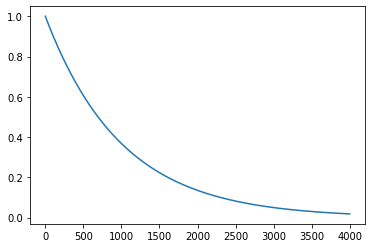

In [20]:
time = np.arange(0,4000)
epsilon = []
for i in range(0,4000):
    epsilon.append(0 + (1 - 0) * np.exp(-0.001*i))
plt.plot(time, epsilon)
plt.show()

In [21]:
#Printing the action space
m = 5

print([(pick,drop) for pick in range(m) for drop in range(m) if pick!=drop or pick==0])

[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (1, 0), (1, 2), (1, 3), (1, 4), (2, 0), (2, 1), (2, 3), (2, 4), (3, 0), (3, 1), (3, 2), (3, 4), (4, 0), (4, 1), (4, 2), (4, 3)]
